Testing Empirical cumulative distribution in 2-D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import warnings


def loadData(files, days=5*365):
    years=days/365
    dataFrames_in = []
    start_dates = []
    end_dates =[]
    
    for file in files:
        df_in = pd.read_csv('C:/Users/worc3920/Documents/GitHub/EmpiricalPortfolio/'+file+'.csv', usecols=["Date","Close"])
        df_in = df_in.rename(columns={"Close": "Close_" + file})
        df_in["Date"]=pd.to_datetime(df_in["Date"], infer_datetime_format=True)
        dataFrames_in.append(df_in)
        start_dates.append(df_in.loc[0,"Date"])
        end_dates.append(df_in.loc[df_in.index[-1],"Date"])
    
    df_start = max(start_dates)
    df_end = min(end_dates)
    df = pd.DataFrame()
    df["Date"] = pd.date_range(start=df_start, end=df_end)
    
    for i in range(len(files)):
        df = df.merge(dataFrames_in[i], on='Date', how='left')

    for file in files:
        for i in range(1,len(df)):    
            if np.isnan(df.loc[i,"Close_" + file]):
                df.loc[i, "Close_" + file] = df.loc[i-1, "Close_"+file]
        for i in range(len(df)-days):
            df.loc[i, "Return_" + file] = (df.loc[i+days, "Close_"+file]/df.loc[i, "Close_"+file])**(1/years)-1#annual. return
    #drop last days intries
    return df.drop(columns=["Close_" + file for file in files]).iloc[:-days]

files = ["gspc","gold"]
df = loadData(files)
df.describe()

,Return_gspc,Return_gold
count,17463.000000,17463.000000
mean,0.073982,0.081790
std,0.073119,0.122350
min,-0.100149,-0.184049
25%,0.006656,-0.016140
50%,0.086190,0.048476
75%,0.120627,0.187617
max,0.266187,0.409916


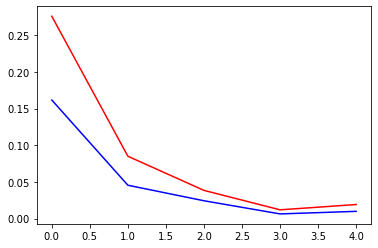

In [2]:
mean_sp=[]
mean_go=[]
std_sp=[]
std_go=[]
for i in range(1,51,10):
    df2=loadData(files,days=i*365)
    mean_sp.append(df2["Return_gspc"].mean())
    mean_go.append(df2["Return_gold"].mean())
    std_sp.append(df2["Return_gspc"].std())
    std_go.append(df2["Return_gold"].std())

ax1 = plt.plot(std_sp,color='b')
ax1 = plt.plot(std_go,color='r')

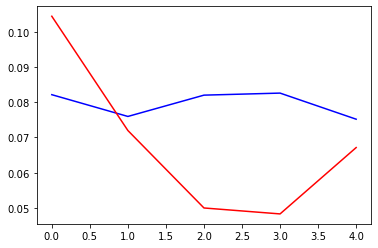

In [3]:
ax2 = plt.plot(mean_sp,color='b')
ax2 = plt.plot(mean_go,color='r')

In [4]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

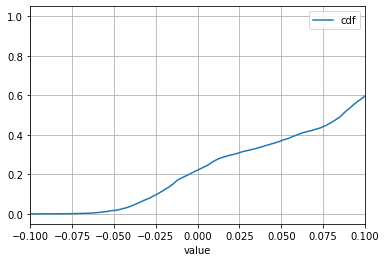

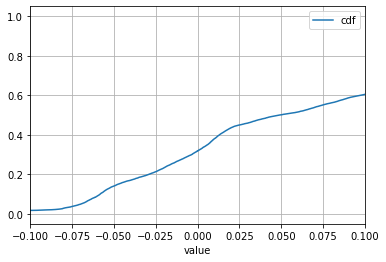

In [2]:
def getEmpiricalDensity(series):
    df2=pd.DataFrame()
    df2["value"]=series
    # Frequency
    stats_df = df2 \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    # Plot
    #stats_df.plot(x = 'value', y = 'pdf', grid = True)
    ax = stats_df.plot(x = 'value', y = 'cdf', xlim=(-0.1,0.1), grid = True)

for file in files:
    getEmpiricalDensity(df["Return_" + file])

,Return_gspc,Return_gold
Return_gspc,1.000000,-0.619693
Return_gold,-0.619693,1.000000


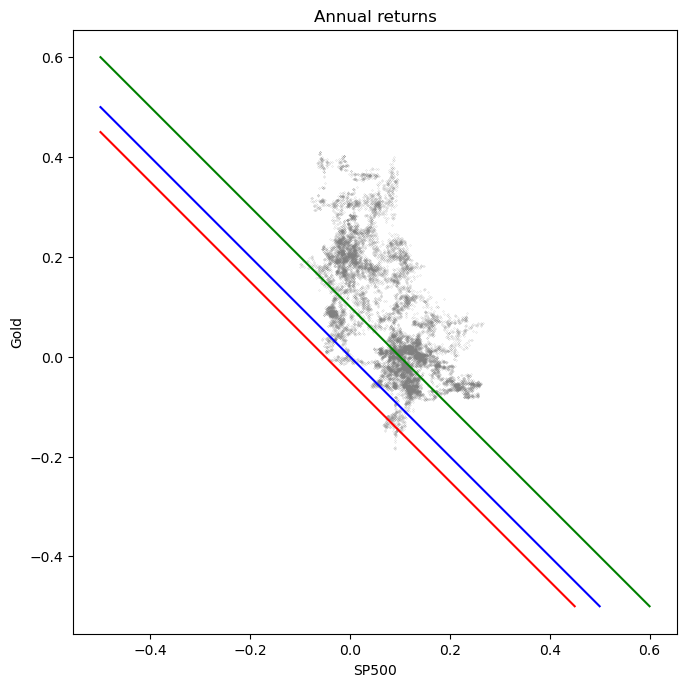

In [3]:
x1 = df["Return_gspc"].to_numpy()
x2 = df["Return_gold"].to_numpy()

fig=plt.figure(figsize = (12,8), dpi = 100)

ax1 = plt.scatter(x1,x2,s=0.01,c='grey')
ax1 = plt.xlabel('SP500')
ax1 = plt.ylabel('Gold')
ax1 = plt.title('Annual returns')

ax1 = plt.plot([-0.5,0.5],[0.5,-0.5],'b')
ax1 = plt.plot([-0.5,0.45],[0.45,-0.5],'r')
ax1 = plt.plot([-0.5,0.6],[0.6,-0.5],'g')
plt.gca().set_aspect('equal', adjustable='box')

df.corr()

In [1]:
#Let's build a MILP
from mip import *

def myopt(x1,x2,alpha, VaR=0, boundary = 10, d=2, max_s = 5):
    n=len(x1)
    n_activeCon = np.ceil(n*(1-alpha)) #number of active constraints that need to be active at solution

    mean_x1=np.mean(x1)
    mean_x2=np.mean(x2)
    
    #find samples that could violate VaR:
    v = []
    for i in range(n):
        if (x2[i] < VaR) | (x1[i] < VaR):
            v.append(i)
    n_v = len(v)


    m = Model(solver_name=CBC)
    w = [ m.add_var(var_type=CONTINUOUS) for dd in range(d) ] #asset weights
    z = [ m.add_var(var_type=BINARY) for vv in range(n_v) ] #active constraints


    #objective
    m.objective = minimize(-(w[0]*mean_x1+w[1]*mean_x2))

    #constaints
    m += xsum(w[dd] for dd in range(d)) == 1
    m += xsum(z[vv] for vv in range(n_v)) == max(0,n_activeCon - (n-n_v)) #n-n_v constraints always satisfied

    for vv in range(n_v):
        m += w[0]*x1[v[vv]]+w[1]*x2[v[vv]] >= (VaR - (1-z[vv])*boundary) #VaR constraint
        
    m += w[0] <= 0.9
    m += w[1] <= 0.9
    
    #obtain model summary
    #m.write('model.lp')
    #m.read('model.lp')
    #print('model has {} vars, {} constraints and {} nzs'.format(m.num_cols, m.num_rows, m.num_nz))

    # optimizing
    status = m.optimize(max_seconds = max_s)
    if status != OptimizationStatus.OPTIMAL:
        print(np.round(alpha,3), np.round(VaR,3), status)
    return m,v

#ax2=plt.plot(alphas,w0Star)
#ax2=plt.plot(alphas,1-w0Star,'r')

In [5]:
#Scenario approach thoughts:
d=2
epsilon = 0.01
beta=10**(-4)
n_bound = np.ceil(2/epsilon*np.log(1/beta)+2*d+2*d/epsilon*np.log(2/epsilon))
print(n_bound)

3966.0


In [2]:
n=len(df)
m,v = myopt(x1,x2,alpha=0.05,VaR=0.0, max_s = 100)

NameError: name 'df' is not defined

In [12]:
d=2
dropped=[]
kept=list(range(n))
for i in range(len(v)):
    if m.vars[i+d].x == 0:
        dropped.append(v[i])
        kept.remove(v[i])        
w0Star = m.vars[0].x
w1Star = m.vars[1].x
print(w0Star,w1Star)

0.4447507429864401 0.5552492570135599


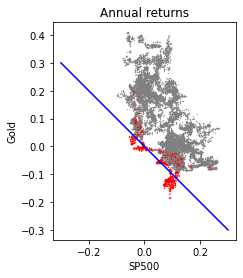

In [13]:
ax3 = plt.scatter(x1[kept],x2[kept],s=0.1,c='grey')
ax3 = plt.scatter(x1[dropped],x2[dropped],s=0.1,c='red')
ax3 = plt.xlabel('SP500')
ax3 = plt.ylabel('Gold')
ax3 = plt.title('Annual returns')

ax1 = plt.plot([-0.3,0.3],[0.3,-0.3],'b')
plt.gca().set_aspect('equal', adjustable='box')

In [12]:
#ax2 = plt.hist(m.vars[0].x*x1[switched_on]+m.vars[1].x*x2[switched_on], density=True,alpha=0.5,color='blue', bins=100)
#ax2 = plt.hist(m.vars[0].x*x1[switched_off]+m.vars[1].x*x2[switched_off], density=True,alpha=0.5,color='red',bins=100)

In [13]:
#Try LP solution appproximation:
from cvxopt.modeling import op, variable, max, sum
import cvxopt

In [33]:
d=2
alpha=0.025
boundary = 1
VaR=0.0
n=len(x1)
n_activeCon = int(np.ceil(n*(1-alpha))) #number of active constraints that need to be active at solution

mean_x1=float(np.mean(x1))
mean_x2=float(np.mean(x2))

#find samples that could violate VaR:
v = []
for i in range(n):
    if (x2[i] < VaR) | (x1[i] < VaR):
        v.append(i)
n_v = int(len(v))

In [34]:
w = variable(d)
print(n_v)
z = variable(n_v,'z') #add [0,1] constraint

#constraints
c1 = (w[0]>=0)
c2 = (w[1]>=0)
c3 = (w[0]+w[1]==1)

b = max(0,n_activeCon - (n-n_v))
c4 = (sum(z) == b)

lp1 = op(w[0]*mean_x1+w[1]*mean_x2, [c1,c2,c3,c4])
for vv in range(n_v):
    lp1.addconstraint((z[vv]>=0))
    lp1.addconstraint((z[vv]<=1))
    lp1.addconstraint((w[0]*float(x1[v[vv]])+w[1]*float(x2[v[vv]]) >= (VaR - (1-z[vv])*boundary))) #VaR constraint

lp1.addconstraint((w[0] <= 0.9))
lp1.addconstraint((w[1] <= 0.9))

lp1.solve()

if lp1.status != 'optimal':
        print("LP solution not optimal")

print(w)

9335
     pcost       dcost       gap    pres   dres   k/t
 0:  7.7742e-02 -1.8672e+04  1e+04  6e-16  7e+02  1e+00
 1:  7.7742e-02 -1.8682e+02  1e+02  1e-15  7e+00  1e-02
 2:  7.7738e-02 -1.9633e+00  1e+00  1e-15  8e-02  1e-04
 3:  7.7324e-02 -1.1436e-01  1e-01  2e-15  8e-03  1e-05
 4:  7.5094e-02 -1.0175e-01  1e-01  2e-16  7e-03  8e-06
 5:  7.4766e-02 -5.5112e-02  7e-02  3e-16  5e-03  5e-06
 6:  7.5403e-02 -4.6655e-02  7e-02  7e-16  5e-03  4e-06
 7:  7.4769e-02  5.2394e-03  4e-02  1e-15  3e-03  2e-06
 8:  7.4858e-02  4.2358e-02  2e-02  2e-16  1e-03  6e-07
 9:  7.4843e-02  6.9435e-02  3e-03  9e-16  2e-04  1e-07
10:  7.4764e-02  7.4687e-02  4e-05  1e-15  3e-06  2e-09
11:  7.4763e-02  7.4762e-02  4e-07  2e-16  3e-08  2e-11
12:  7.4763e-02  7.4763e-02  4e-09  7e-16  3e-10  2e-13
Optimal solution found.
variable of length 2
value: 
[ 9.00e-01]
[ 1.00e-01]

